# **Milestone 1 Phase 2**

Name: Julio Putra David

Batch: 10

Heroku deployment: https://h8-ml2-churn-predictor-julio.herokuapp.com/
_______________

## **1. Introduction**

This notebook will cover the implementation of Artificial Neural Network on a prediction about whether the customers of a telco company will churn or not. The dataset contains information about a Telco Company in California that provided phone and internet services who had already had 7043 customers in the third quarter of the year. 

## **2. Import Libraries**

In [1]:
# Basic Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from scipy.stats import pearsonr
import pickle

# Pre-processing Libraries
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer, OutlierTrimmer
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

# Deep Learning Algorithm Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout

# Model Evaluation Libraries
from sklearn.metrics import classification_report

# Pipeline Libraries
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Warning Neglect Library
import warnings
warnings.filterwarnings('ignore')

## **3. Data Loading**

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
r = df.shape[0]
c = df.shape[1]
print('Number of rows    =', r)
print('Number of columns =', c)

Number of rows    = 7043
Number of columns = 21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Make a copy of the original dataset

In [5]:
data = df.copy()

## **4. Exploratory Data Analysis (EDA)**

#### **1. List of numerical columns**

In [6]:
num_data = data.select_dtypes(include=np.number).columns
num_data

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')

#### **2. List of Categorical Columns**

In [7]:
data.select_dtypes(include=['object']).columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges',
       'Churn'],
      dtype='object')

We have 3 numerical columns and 18 categorical columns. However, if we look at the columns in detail, we will notice that `SeniorCitizen` column is categorical since it provides the information whether the customer is a senior citizen or not represented by **0 = No** and **1 = Yes**.

#### **3. Descriptive Statistics**

In [8]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


* From the descriptive statistics, it seems that there are a few outliers in `tenure` and `MonthlyCharges`. 
* The `SeniorCitizen` column is proven to be a categorical data since we only have the value of 0 and 1 in the column.
* It seems that `tenure` and `MonthlyCharges` have normal distribution since the `mean` and `Q2` are not that far.

#### **4. Missing Values Detection**

In [9]:
data.isnull().values.any()

False

Now we will check if there are any unexpected missing values or not by seeing the unique values of each categorical column.

In [10]:
for i in data.select_dtypes(include=['object']).columns:
    print(f'{i} :', data[i].unique())

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn : ['No' 'Yes']


We cannot say that there aren't any missing values in the dataset yet, because if we take a look at the `TotalCharges` column, it's supposed to be numerical but instead it was written in string type. We will convert it into numerical form and check the missing values again later in the Data Pre-processing section.

#### **5. Distribution of Features**

In [11]:
for feature in num_data.drop('SeniorCitizen'):
    skewness = data[feature].skew(axis = 0, skipna = True)
    if skewness <= 0.5 and skewness >= -0.5:
        print(f'{feature} = Normal Distribution')
    else:
        print(f'{feature} = Skewed')

tenure = Normal Distribution
MonthlyCharges = Normal Distribution


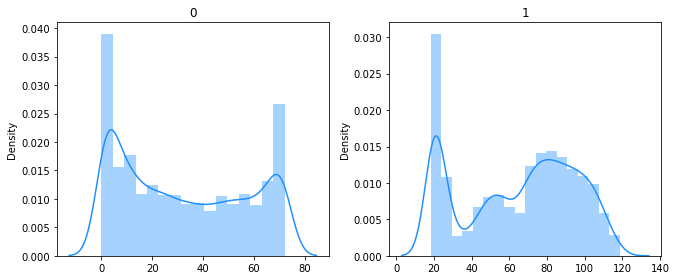

In [12]:
plt.figure(figsize=(14,4))
for i in range(0,len(num_data.drop('SeniorCitizen'))):
    plt.subplot(1,3, i+1)
    sns.distplot(x=data[num_data.drop('SeniorCitizen')[i]], color='dodgerblue')
    plt.title(f'{i}')
    plt.tight_layout()

The distribution of `tenure` and `MonthlyCharges` are normal. Thus, we will use z-score in handling their outliers (if any).

#### **6. Boxplot Analysis**

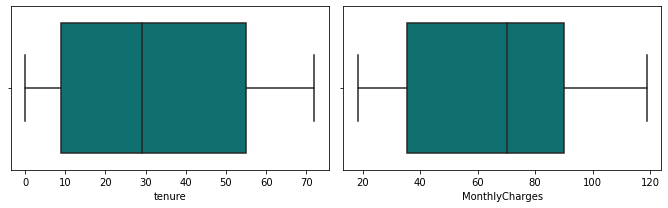

In [13]:
plt.figure(figsize=(14,3))
for i in range(0,len(num_data.drop('SeniorCitizen'))):
    plt.subplot(1,3, i+1)
    sns.boxplot(x=data[num_data.drop('SeniorCitizen')[i]], color='teal')
    plt.tight_layout()

There seems to be no outliers on our numerical data.

#### **6. Churn (Target Variable)**

No     5174
Yes    1869
Name: Churn, dtype: int64


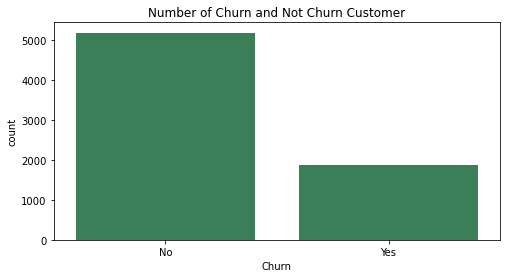

In [14]:
print(data.Churn.value_counts())

plt.figure(figsize=(8,4))
sns.countplot(data.Churn, color='seagreen')
plt.title('Number of Churn and Not Churn Customer')
plt.show()

The target class is **imbalanced**

#### **7. Gender**

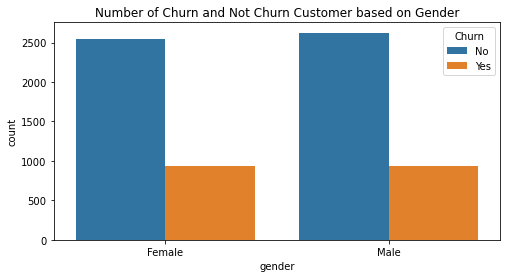

In [15]:
plt.figure(figsize=(8,4))
sns.countplot(data.gender, hue=data.Churn)
plt.title('Number of Churn and Not Churn Customer based on Gender')
plt.show()

There are more customers that are not churned.

#### **8. Senior Citizen**

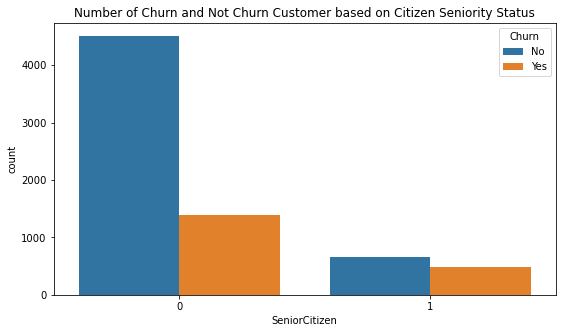

In [16]:
plt.figure(figsize=(9,5))
sns.countplot(data.SeniorCitizen, hue=data.Churn)
plt.title('Number of Churn and Not Churn Customer based on Citizen Seniority Status')
plt.show()

There are more non-senior citizen and most of them are not churned.

#### **9. Partner**

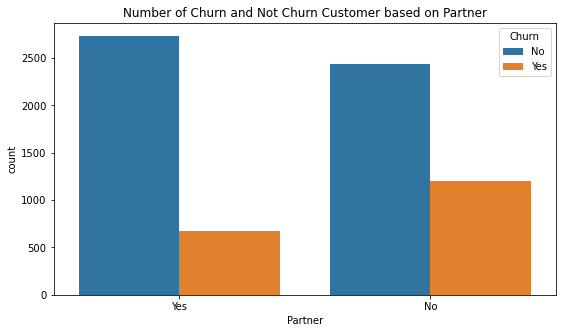

In [17]:
plt.figure(figsize=(9,5))
sns.countplot(data.Partner, hue=data.Churn)
plt.title('Number of Churn and Not Churn Customer based on Partner')
plt.show()

There are more customers who has a phone service and most of them are not churned.

#### **10. Dependents**

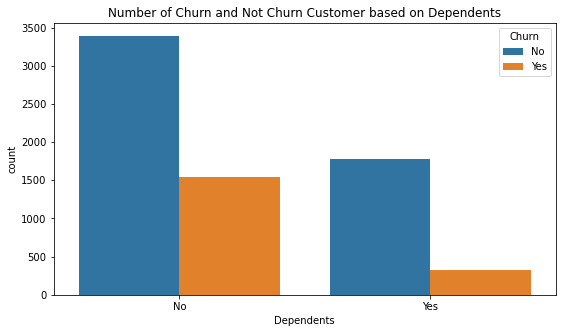

In [18]:
plt.figure(figsize=(9,5))
sns.countplot(data.Dependents, hue=data.Churn)
plt.title('Number of Churn and Not Churn Customer based on Dependents')
plt.show()

Customers with dependents tend not to churn.

#### **11. PhoneService**

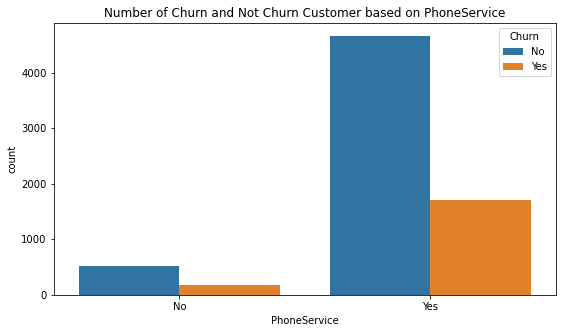

In [19]:
plt.figure(figsize=(9,5))
sns.countplot(data.PhoneService, hue=data.Churn)
plt.title('Number of Churn and Not Churn Customer based on PhoneService')
plt.show()

There are more customers with phone service tend to churn.

#### **12. Internet Service**

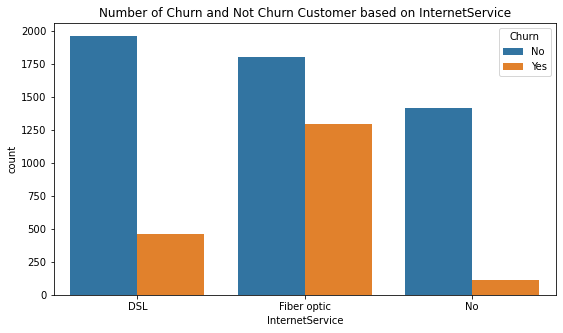

In [20]:
plt.figure(figsize=(9,5))
sns.countplot(data.InternetService, hue=data.Churn)
plt.title('Number of Churn and Not Churn Customer based on InternetService')
plt.show()

#### **13. Contract**

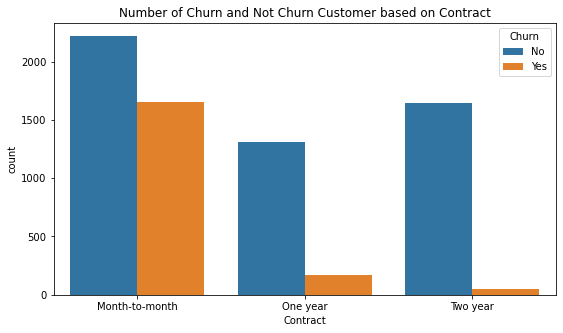

In [21]:
plt.figure(figsize=(9,5))
sns.countplot(data.Contract, hue=data.Churn)
plt.title('Number of Churn and Not Churn Customer based on Contract')
plt.show()

Month-to-month have the most customers and more likely not to churn.

## **5. Data Pre-processing**

### **5.1 Feature Engineering**

Convert `TotalCharges` into numerical value

In [22]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

Convert `SeniorCitizen` into string

In [23]:
data['SeniorCitizen'] = data.SeniorCitizen.replace({0:'No', 1:'Yes'})

Drop `customerID`

In [24]:
data.drop('customerID', axis=1, inplace=True)

Convert `Churn` into integer

In [25]:
data['Churn'] = data.Churn.replace({'No':0, 'Yes':1})

### **5.2 Inference Dataset**

We will take out 10 samples from the dataset to be our inference dataset.

In [26]:
data_inf = data.sample(10, random_state=77)

Dropping the data that has been assigned as inference.

In [27]:
data.drop(data_inf.index, inplace=True)

Resetting the index to prevent unwanted errors.

In [28]:
data.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

### **5.3 Data Splitting**

We will split into Train-set, Validation-set, and Test-set

In [29]:
X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=46)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=46)

In [30]:
print('Size of feature training data    :', X_train.shape)
print('Size of target training data     :', y_train.shape)
print('='*50)
print('Size of feature validation data  :', X_val.shape)
print('Size of target validation data   :', y_val.shape)
print('='*50)
print('Size of feature testing data     :', X_test.shape)
print('Size of target testing data      :', y_test.shape)

Size of feature training data    : (5380, 19)
Size of target training data     : (5380,)
Size of feature validation data  : (598, 19)
Size of target validation data   : (598,)
Size of feature testing data     : (1055, 19)
Size of target testing data      : (1055,)


### **5.4 Handling Outliers**

In [31]:
# This is the function to detect how many outliers in each column

def detect_otl(data, column):
    skewness = data[column].skew(axis = 0, skipna = True)
    if skewness <= 0.5 and skewness >= -0.5:
        upper_boundary = data[column].mean() + 1.5 * data[column].std()
        lower_boundary = data[column].mean() - 1.5 * data[column].std()
        print(f'[Gaussian] Skewness of {column} =', skewness)
        print('% above upper boundary : {}'.format(len(data[data[column] > upper_boundary]) / len(data) * 100))
        print('% below lower boundary : {}'.format(len(data[data[column] < lower_boundary]) / len(data) * 100))
        print('-'*75)
    else:
        IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
        lower_boundary = data[column].quantile(0.25) - (IQR * 1.5)
        upper_boundary = data[column].quantile(0.75) + (IQR * 1.5)
        print(f'[Skewed] Skewness of {column} =', skewness)
        print('% above upper boundary : {}'.format(len(data[data[column] > upper_boundary]) / len(data) * 100))
        print('% below lower boundary : {}'.format(len(data[data[column] < lower_boundary]) / len(data) * 100))
        print('-'*75)

In [32]:
for i in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    detect_otl(X_train, i)

[Gaussian] Skewness of tenure = 0.24538626299377125
% above upper boundary : 10.483271375464684
% below lower boundary : 0.0
---------------------------------------------------------------------------
[Gaussian] Skewness of MonthlyCharges = -0.2110372949556631
% above upper boundary : 3.197026022304833
% below lower boundary : 2.490706319702602
---------------------------------------------------------------------------
[Skewed] Skewness of TotalCharges = 0.9688685792782247
% above upper boundary : 0.0
% below lower boundary : 0.0
---------------------------------------------------------------------------


Since all `tenure` and `MonthlyCharges` have more than 5% outliers, We will cap the outliers.

In [33]:
winsorizer = Winsorizer(capping_method='gaussian', 
                        tail='both',
                        fold=1.5,
                        variables=['tenure', 'MonthlyCharges'])

X_train_capped = winsorizer.fit_transform(X_train)
print('X_train dataset - Before Capping')
print(X_train.describe())
print('')
print('X_train dataset - After Capping')
print(X_train_capped.describe())

X_train dataset - Before Capping
            tenure  MonthlyCharges  TotalCharges
count  5380.000000     5380.000000   5371.000000
mean     32.223606       64.623383   2270.380953
std      24.503730       30.137612   2256.189627
min       0.000000       18.250000     18.850000
25%       9.000000       35.337500    390.175000
50%      29.000000       70.250000   1391.650000
75%      55.000000       89.962500   3769.850000
max      72.000000      118.650000   8670.100000

X_train dataset - After Capping
            tenure  MonthlyCharges  TotalCharges
count  5380.000000     5380.000000   5371.000000
mean     32.000608       64.522974   2270.380953
std      24.153531       29.960602   2256.189627
min       0.000000       19.416965     18.850000
25%       9.000000       35.337500    390.175000
50%      29.000000       70.250000   1391.650000
75%      55.000000       89.962500   3769.850000
max      68.979201      109.829800   8670.100000


### **5.5 Handling Missing Values**

First, we will check number of missing values in X_train and X_test.

In [34]:
X_train_capped.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        9
dtype: int64

In [35]:
X_val.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [36]:
X_test.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        2
dtype: int64

In [37]:
data.loc[data.isna().any(axis=1)].tail()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3821,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
4375,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5212,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6661,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0
6744,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,0


In [38]:
for feature in ['TotalCharges']:
    skewness = data[feature].skew(axis = 0, skipna = True)
    if skewness <= 0.5 and skewness >= -0.5:
        print(f'{feature} = Normal Distribution')
    else:
        print(f'{feature} = Skewed')

TotalCharges = Skewed


The missing values in `TotalCharges` are categorized as MCAR (Missing Completely At Random) because there are no other columns that explain why the data was missing. It could be human error. Thus, we will impute them with its median since the distribution is skewed.

In [39]:
imputer = MeanMedianImputer(imputation_method='median', variables=['TotalCharges'])

X_train_pre = imputer.fit_transform(X_train)
X_test_pre = imputer.fit_transform(X_test)

Just to avoid confusion, we will also make a new variable for X validation set.

In [40]:
X_val_pre = X_val.copy()

### **5.6 Feature Selection**

We will check the correlation of each feature to the target variable using Pearson Correlation.

In [41]:
y_train_df = pd.DataFrame(y_train, columns=['Churn'])

In [42]:
feature_selection = X_train_pre.copy()
feature_selection['Churn'] = y_train_df['Churn']
feature_selection.shape

(5380, 20)

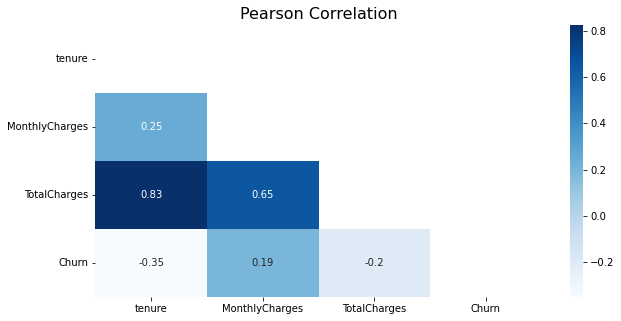

In [43]:
plt.figure(figsize=(10,5))
sns.heatmap(feature_selection.corr(),annot=True, mask=np.triu(feature_selection.corr()), cmap='Blues')
plt.title('Pearson Correlation', fontsize=16)
plt.show()

We will not drop any features since the correlation is quite strong.

### **5.7 Feature Scaling and Encoding**

#### **5.7.1 Splitting Numerical and Categorical Columns**

We will divide the columns into 3 groups, which are Numerical, Binary Class, and Multiclass.

In [45]:
num_columns = X_train_pre.select_dtypes(include=np.number).columns.tolist()
bin_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService']
mcl_columns = ['InternetService', 'MultipleLines','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

In [46]:
X_train_num = X_train_pre[num_columns]
X_train_bin = X_train_pre[bin_columns]
X_train_mcl = X_train_pre[mcl_columns]

X_val_num = X_val_pre[num_columns]
X_val_bin = X_val_pre[bin_columns]
X_val_mcl = X_val_pre[mcl_columns]

X_test_num = X_test_pre[num_columns]
X_test_bin = X_test_pre[bin_columns]
X_test_mcl = X_test_pre[mcl_columns]

#### **5.7.2 Feature Scaling**

In [47]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_num)
X_val_scaled = scaler.fit_transform(X_val_num)
X_test_scaled = scaler.transform(X_test_num)

#### **5.7.3 Feature Encoding**

For Binary Class data, we will encode it with Ordinal Encoder, for the Multiclass data we will encode it using One-Hot Encoder

In [48]:
ord_encoder = OrdinalEncoder()
ohe_encoder = OneHotEncoder()

X_train_ord = ord_encoder.fit_transform(X_train_bin)
X_val_ord = ord_encoder.fit_transform(X_val_bin)
X_test_ord = ord_encoder.fit_transform(X_test_bin)

X_train_ohe = ohe_encoder.fit_transform(X_train_mcl).toarray()
X_val_ohe = ohe_encoder.fit_transform(X_val_mcl).toarray()
X_test_ohe = ohe_encoder.fit_transform(X_test_mcl).toarray()

#### **5.7.4 Concat Scaled and Encoded Data**

In [49]:
X_train_concat = np.concatenate([X_train_scaled, X_train_ord, X_train_ohe], axis = 1)
X_val_concat = np.concatenate([X_val_scaled, X_val_ord, X_val_ohe], axis = 1)
X_test_concat = np.concatenate([X_test_scaled, X_test_ord, X_test_ohe], axis = 1)

print(X_train_concat.shape)
print(X_val_concat.shape)
print(X_test_concat.shape)

(5380, 40)
(598, 40)
(1055, 40)


### **5.8 PCA**

Because the data contains a bit too many columns after pre-processing, we will try to reduce it using PCA. We will tkae 90% information from the dataset.

In [50]:
pca = PCA(n_components=0.9).fit(X_train_concat)

In [51]:
X_train_final = pca.transform(X_train_concat)
X_val_final = pca.transform(X_val_concat)
X_test_final = pca.transform(X_test_concat)

print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

(5380, 15)
(598, 15)
(1055, 15)


We now have 15 principal components.

## **6. Model Definition**

### **6.1 Sequential API**

We want to define 2 models for Sequential API to know the results of using different activation function, number of hidden layers, number of neurons, optimizers, and also using dropout.

#### **6.1.1 Sequential A**

* Activation function: ReLU
* Number of hidden layers: 1
* Optimizer: Adam

In [101]:
seq_model_A = Sequential()
seq_model_A.add(Dense(9, activation='relu',                                       # hidden layer 1
                         input_shape=(15,), 
                         kernel_initializer=tf.keras.initializers.HeUniform()))  
seq_model_A.add(Dense(1, activation='sigmoid'))                                   # output layer

In [102]:
seq_model_A.compile(loss='binary_crossentropy',
                    optimizer='adam', # paling modern
                    metrics=['accuracy'])

#### **6.1.2 Sequential B**

* Activation function: SeLU
* Number of hidden layers: 2
* Optimizer: Gradient Descent
* Using dropout

In [103]:
seq_model_B = Sequential()
seq_model_B.add(Dense(18, activation='relu',                                     # hidden layer 1
                         input_shape=(15,), 
                         kernel_initializer=tf.keras.initializers.HeUniform())) 
seq_model_B.add(Dropout(0.2))                                                         # Dropout
seq_model_B.add(Dense(9, activation='relu'))                                          # hidden layer 2
seq_model_B.add(Dropout(0.2))                                                         # Dropout
seq_model_B.add(Dense(1, activation='sigmoid'))                                 # output layer

In [104]:
seq_model_B.compile(loss='binary_crossentropy',
                    optimizer='SGD',
                    metrics=['accuracy'])

### **6.2 Functional API**

We will build the Functional API using the same hyperparameters as Sequential A.

In [105]:
data_input = Input(shape=(15,))
hidden_1 = Dense(9, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform())(data_input)
output_layer = Dense(1, activation='sigmoid')(hidden_1)
func_model = Model(inputs=data_input, outputs=output_layer)

In [106]:
func_model.compile(loss="binary_crossentropy", 
                   optimizer='adam',
                   metrics=['accuracy'])

## **7. Model Training**

### **7.1 Sequential API A**

In [107]:
history_a = seq_model_A.fit(X_train_final, y_train, epochs=25, validation_data=(X_val_final, y_val))

Epoch 1/25
169/169 [==============================] - 1s 3ms/step - loss: 0.6673 - accuracy: 0.6117 - val_loss: 0.5709 - val_accuracy: 0.7174
Epoch 2/25
169/169 [==============================] - 0s 2ms/step - loss: 0.5296 - accuracy: 0.7372 - val_loss: 0.4931 - val_accuracy: 0.7592
Epoch 3/25
169/169 [==============================] - 0s 2ms/step - loss: 0.4705 - accuracy: 0.7734 - val_loss: 0.4530 - val_accuracy: 0.7876
Epoch 4/25
169/169 [==============================] - 0s 2ms/step - loss: 0.4451 - accuracy: 0.7894 - val_loss: 0.4367 - val_accuracy: 0.8043
Epoch 5/25
169/169 [==============================] - 0s 2ms/step - loss: 0.4358 - accuracy: 0.7935 - val_loss: 0.4284 - val_accuracy: 0.7993
Epoch 6/25
169/169 [==============================] - 0s 3ms/step - loss: 0.4309 - accuracy: 0.7948 - val_loss: 0.4237 - val_accuracy: 0.7993
Epoch 7/25
169/169 [==============================] - 0s 2ms/step - loss: 0.4282 - accuracy: 0.7968 - val_loss: 0.4209 - val_accuracy: 0.8010
Epoch 

### **7.2 Sequential API B**

In [108]:
history_b = seq_model_B.fit(X_train_final, y_train, epochs=25, validation_data=(X_val_final, y_val))

Epoch 1/25
169/169 [==============================] - 1s 3ms/step - loss: 0.6908 - accuracy: 0.6156 - val_loss: 0.6370 - val_accuracy: 0.7408
Epoch 2/25
169/169 [==============================] - 0s 2ms/step - loss: 0.6158 - accuracy: 0.7305 - val_loss: 0.5906 - val_accuracy: 0.7458
Epoch 3/25
169/169 [==============================] - 0s 2ms/step - loss: 0.5828 - accuracy: 0.7362 - val_loss: 0.5615 - val_accuracy: 0.7458
Epoch 4/25
169/169 [==============================] - 0s 2ms/step - loss: 0.5606 - accuracy: 0.7381 - val_loss: 0.5370 - val_accuracy: 0.7458
Epoch 5/25
169/169 [==============================] - 0s 2ms/step - loss: 0.5404 - accuracy: 0.7401 - val_loss: 0.5142 - val_accuracy: 0.7441
Epoch 6/25
169/169 [==============================] - 0s 2ms/step - loss: 0.5173 - accuracy: 0.7578 - val_loss: 0.4925 - val_accuracy: 0.7542
Epoch 7/25
169/169 [==============================] - 0s 2ms/step - loss: 0.5046 - accuracy: 0.7610 - val_loss: 0.4765 - val_accuracy: 0.7742
Epoch 

### **7.3 Functional API**

In [109]:
history_c = func_model.fit(X_train_final, y_train, epochs=25, validation_data=(X_val_final, y_val))

Epoch 1/25
169/169 [==============================] - 1s 3ms/step - loss: 0.5556 - accuracy: 0.7257 - val_loss: 0.4963 - val_accuracy: 0.7726
Epoch 2/25
169/169 [==============================] - 0s 2ms/step - loss: 0.4715 - accuracy: 0.7719 - val_loss: 0.4518 - val_accuracy: 0.7910
Epoch 3/25
169/169 [==============================] - 0s 2ms/step - loss: 0.4434 - accuracy: 0.7913 - val_loss: 0.4356 - val_accuracy: 0.7977
Epoch 4/25
169/169 [==============================] - 0s 3ms/step - loss: 0.4333 - accuracy: 0.7946 - val_loss: 0.4289 - val_accuracy: 0.8043
Epoch 5/25
169/169 [==============================] - 0s 2ms/step - loss: 0.4285 - accuracy: 0.7976 - val_loss: 0.4246 - val_accuracy: 0.7977
Epoch 6/25
169/169 [==============================] - 0s 2ms/step - loss: 0.4258 - accuracy: 0.8007 - val_loss: 0.4223 - val_accuracy: 0.7993
Epoch 7/25
169/169 [==============================] - 0s 2ms/step - loss: 0.4237 - accuracy: 0.8002 - val_loss: 0.4205 - val_accuracy: 0.7993
Epoch 

## **8. Model Evaluation**

### **8.1 Sequential API A**

In [110]:
y_pred_a = seq_model_A.predict(X_test_final)
y_pred_a = np.where(y_pred_a >= 0.5, 1, 0)
print(classification_report(y_test, y_pred_a))

33/33 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       756
           1       0.66      0.57      0.61       299

    accuracy                           0.80      1055
   macro avg       0.75      0.73      0.74      1055
weighted avg       0.79      0.80      0.79      1055



In [111]:
metrics_a = pd.DataFrame(history_a.history)
metrics_a.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.414716,0.805576,0.407927,0.804348
21,0.414100,0.803160,0.407745,0.802676
22,0.413703,0.805390,0.407330,0.806020
23,0.412939,0.805762,0.407776,0.802676
24,0.412640,0.806134,0.407823,0.804348


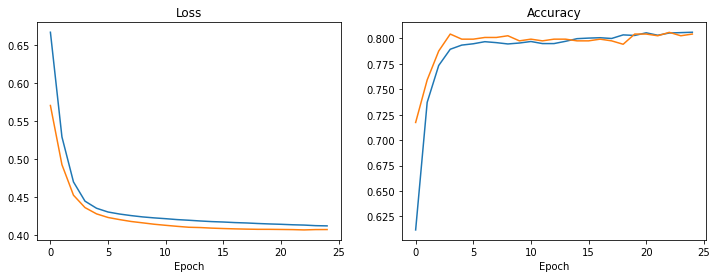

In [112]:
fig,ax=plt.subplots(ncols=2,figsize=(12,4))

ax[0].plot(metrics_a[['loss', 'val_loss']])
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')

ax[1].plot(metrics_a[['accuracy', 'val_accuracy']])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')

plt.show()

Sequential API A shows accuracy of **0.79**, and the graph above shows that the fitting is just right. There aren't any exploding gradient or vanishing gradient detected.

### **8.2 Sequential API B**

In [113]:
y_pred_b = seq_model_B.predict(X_test_final)
y_pred_b = np.where(y_pred_b >= 0.5, 1, 0)
print(classification_report(y_test, y_pred_b))

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       756
           1       0.66      0.38      0.49       299

    accuracy                           0.77      1055
   macro avg       0.73      0.65      0.67      1055
weighted avg       0.76      0.77      0.75      1055



In [114]:
metrics_b = pd.DataFrame(history_b.history)
metrics_b.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.468732,0.772305,0.430099,0.799331
21,0.467331,0.774164,0.429621,0.797659
22,0.460816,0.771933,0.429444,0.802676
23,0.460535,0.775279,0.428879,0.799331
24,0.457977,0.779740,0.428238,0.806020


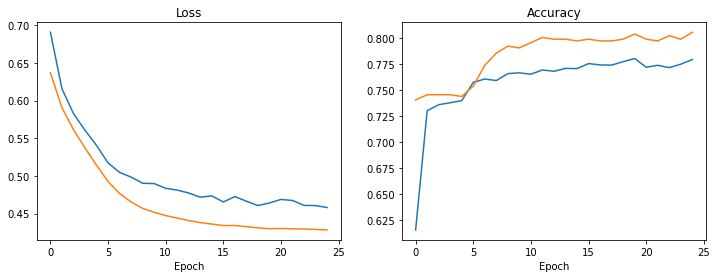

In [115]:
fig,ax=plt.subplots(ncols=2,figsize=(12,4))

ax[0].plot(metrics_b[['loss', 'val_loss']])
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')

ax[1].plot(metrics_b[['accuracy', 'val_accuracy']])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')

plt.show()

Sequential API B shows accuracy of **0.77** same with Seqeuntial API A, and the graph above shows that the fitting is just right. There aren't any significant exploding gradient or vanishing gradient detected as well. However, the graph of Sequential API A is better since the train and validation line in Sequential API A are closer than Sequential API B.

### **8.3 Functional API**

In [116]:
y_pred_c = func_model.predict(X_test_final)
y_pred_c = np.where(y_pred_c >= 0.5, 1, 0)
print(classification_report(y_test, y_pred_c))

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       756
           1       0.65      0.56      0.60       299

    accuracy                           0.79      1055
   macro avg       0.74      0.72      0.73      1055
weighted avg       0.78      0.79      0.78      1055



In [117]:
metrics_c = pd.DataFrame(history_c.history)
metrics_c.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.413698,0.807435,0.412293,0.804348
21,0.413360,0.806506,0.412143,0.802676
22,0.412987,0.806877,0.411724,0.804348
23,0.412525,0.806506,0.411305,0.806020
24,0.412334,0.806877,0.411413,0.807692


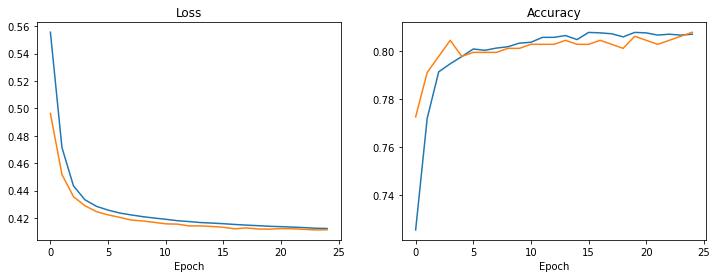

In [118]:
fig,ax=plt.subplots(ncols=2,figsize=(12,4))

ax[0].plot(metrics_c[['loss', 'val_loss']])
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')

ax[1].plot(metrics_c[['accuracy', 'val_accuracy']])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')

plt.show()

Funtional API have the same hyperparameters as Sequential API A, therefore teh modelling is actually the same.

## **9. Model Saving**

### **9.1 Pipeline**

In [119]:
# Define pipeline for train, val, and test set
train_set = tf.data.Dataset.from_tensor_slices((X_train_final, y_train))
train_set = train_set.batch(50)

val_set = tf.data.Dataset.from_tensor_slices((X_val_final, y_val))
val_set = val_set.batch(50)

test_set = tf.data.Dataset.from_tensor_slices((X_test_final, y_test))
test_set = test_set.batch(50)

# Define the model
model_pipe = Sequential()
model_pipe.add(Dense(9, input_shape=(15,), activation="relu", kernel_initializer=tf.keras.initializers.HeUniform()))
model_pipe.add(Dense(1, activation="sigmoid"))
model_pipe.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
                   
model_pipe.fit(train_set, epochs=25, validation_data=val_set)

Epoch 1/25
108/108 [==============================] - 1s 4ms/step - loss: 0.9138 - accuracy: 0.4680 - val_loss: 0.7333 - val_accuracy: 0.5635
Epoch 2/25
108/108 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.6004 - val_loss: 0.5941 - val_accuracy: 0.6656
Epoch 3/25
108/108 [==============================] - 0s 2ms/step - loss: 0.5758 - accuracy: 0.6773 - val_loss: 0.5315 - val_accuracy: 0.7140
Epoch 4/25
108/108 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.7333 - val_loss: 0.4966 - val_accuracy: 0.7525
Epoch 5/25
108/108 [==============================] - 0s 2ms/step - loss: 0.4938 - accuracy: 0.7613 - val_loss: 0.4744 - val_accuracy: 0.7726
Epoch 6/25
108/108 [==============================] - 0s 2ms/step - loss: 0.4724 - accuracy: 0.7809 - val_loss: 0.4587 - val_accuracy: 0.7876
Epoch 7/25
108/108 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.7874 - val_loss: 0.4472 - val_accuracy: 0.7960
Epoch 

In [120]:
model_pipe.save('churn_model.h5')

### **9.2 Preprocessing Pipeline**

In [121]:
# Numerical pipeline
num_pipe = make_pipeline(Winsorizer(capping_method='gaussian', 
                                    tail='both',
                                    fold=1.5,
                                    missing_values='ignore'),
                         MeanMedianImputer(imputation_method='median'),
                         StandardScaler())

# Binary Class pipeline
bin_pipe = make_pipeline(OrdinalEncoder())

# Multiclass pipeline
mcl_pipe = make_pipeline(OneHotEncoder())

preprocess_pipeline = Pipeline(steps=[("normalization", ColumnTransformer(transformers=[('num_input', num_pipe, num_columns),
                                                                                        ('bin_input', bin_pipe, bin_columns),
                                                                                        ('mcl_input', mcl_pipe, mcl_columns)
                                                                                       ], remainder='passthrough')),
                                      ("reduction", PCA(n_components=0.9))], verbose=True)

preprocess_pipeline.fit(X_train)

with open("churn_preprocessing.pkl", "wb") as f:
    pickle.dump(preprocess_pipeline, f)

[Pipeline] ..... (step 1 of 2) Processing normalization, total=   0.1s
[Pipeline] ......... (step 2 of 2) Processing reduction, total=   0.0s


## **10. Model Inference**

In [122]:
data_inf.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,Yes,71,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),24.70,1810.55,0
1,Female,No,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.50,74.50,1
2,Male,No,Yes,Yes,35,Yes,Yes,DSL,No,No,No,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),73.45,2661.10,0
3,Male,No,Yes,Yes,36,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),25.10,930.95,0
4,Female,No,No,No,9,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.20,633.85,0


#### **Check missing values**

In [123]:
data_inf.isnull().any()

gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

#### **Separate target variable**

In [125]:
data_inf_X = data_inf[X_train_pre.columns]
data_inf_y = data_inf['Churn']

#### **Data Pre-processing**

In [126]:
data_inf_final = preprocess_pipeline.transform(data_inf_X)

#### **Prediction**

In [127]:
churn_model = load_model('churn_model.h5')
churn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 9)                 144       
                                                                 
 dense_24 (Dense)            (None, 1)                 10        
                                                                 
Total params: 154
Trainable params: 154
Non-trainable params: 0
_________________________________________________________________


In [128]:
y_pred_inf = churn_model.predict(data_inf_final)

1/1 [==============================] - 0s 58ms/step


In [129]:
y_pred_inf = np.where(y_pred_inf < 0.5, 0, 1)
y_pred_inf = pd.DataFrame(y_pred_inf, columns=['predicted_Churn'])
y_pred_inf['predicted_Churn'] = y_pred_inf.predicted_Churn.replace({0:'No', 1:'Yes'})

In [130]:
y_pred_inf

,predicted_Churn
0,No
1,Yes
2,No
3,No
4,Yes
5,No
6,No
7,No
8,Yes
9,Yes


The model is working well with the data inference.

## **11. Conclusion**

Tensorflow is a powerful deep learning algorithm. In this case, we predicted whether the customers of a Telco Company will churn or not. 

We used 2 methods, Sequential API and Functional API. For the sequential API we try to define 2 models using different activation function, optimizer, and number of hidden layers and neurons. The result was not too significant, the accuracy of Sequential API A is **0.80** and B is **0.79**. However from the loss and accuracy plot we could see that the train and validation loss and accuracy in Sequential API A shows closer lines than Sequential API B. This means that we do not need many layers if using 1 hidden layer is already good.

We also used PCA before we input the data to the model, and it showed a good result. At the first attempt I did not use PCA so I input 40 features to the model and the result was not satisfactory. So I tried to reduce the features using PCA and it showed a significant improvement.

In this case, the activation function that we used is **`ReLU`**, the optimizer is **`Adam`**, the weight initializer is **`HeUniform`**, 1 hidden layer, and no dropout.